# Reed-Shepp Path Planning

This notebook implements the Reed-Shepp path planning algorithm for car-like mobile robots.
Reed-Shepp paths are optimal paths for vehicles with forward and reverse capabilities and a minimum turning radius.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from math import sin, cos, pi, tan, atan2, sqrt, acos
from enum import IntEnum

# For visualization
%matplotlib inline

## Reed-Shepp Path Types

There are 48 different types of Reed-Shepp paths, classified into 5 main categories:
- CSC (Circle-Straight-Circle)
- CCC (Circle-Circle-Circle)
- CCCC (Circle-Circle-Circle-Circle)
- CCSC (Circle-Circle-Straight-Circle)
- CCSCC (Circle-Circle-Straight-Circle-Circle)

We'll implement all path types and find the shortest one.

In [24]:
class Path:
    """Class to represent a Reed-Shepp path"""
    
    class Gear(IntEnum):
        FORWARD = 1
        BACKWARD = -1
    
    class Steering(IntEnum):
        STRAIGHT = 0
        LEFT = 1
        RIGHT = -1
    
    def __init__(self):
        self.lengths = []
        self.ctypes = []
        self.total_length = 0.0
        self.gear = []  # forward or backward
        self.steering = []  # straight, left or right

    def append_segment(self, length, ctype, gear, steering):
        self.lengths.append(length)
        self.ctypes.append(ctype)
        self.gear.append(gear)
        self.steering.append(steering)
        self.total_length += abs(length)

    def __repr__(self):
        result = f"Total length: {self.total_length:.4f}\nPath segments:\n"
        for i in range(len(self.lengths)):
            gear_str = "FORWARD" if self.gear[i] == Path.Gear.FORWARD else "BACKWARD"
            if self.steering[i] == Path.Steering.STRAIGHT:
                steer_str = "STRAIGHT"
            elif self.steering[i] == Path.Steering.LEFT:
                steer_str = "LEFT"
            else:
                steer_str = "RIGHT"
            
            result += f"  Segment {i+1}: length={abs(self.lengths[i]):.4f}, {gear_str}, {steer_str}\n"
        return result

In [25]:
class ReedShepp:
    """Reed-Shepp path planner"""
    
    def __init__(self, radius=1.0):
        self.radius = radius  # minimum turning radius
    
    def _mod2pi(self, theta):
        """Normalize angle to [-pi, pi]"""
        return theta - 2.0 * pi * round(theta / (2.0 * pi))

    def calc_shortest_path(self, sx, sy, syaw, gx, gy, gyaw):
        """Find the shortest Reed-Shepp path"""
        # Convert goal pose to relative coordinate from start pose
        dx = gx - sx
        dy = gy - sy
        dyaw = gyaw - syaw
        
        # Coordinate conversion to standard form (local frame)
        c = cos(-syaw)  # Note the negative angle for proper transformation
        s = sin(-syaw)
        x = (c * dx) - (s * dy)  # Changed signs in transformation
        y = (s * dx) + (c * dy)
        yaw = self._mod2pi(dyaw)
        
        # Find all possible paths
        paths = self._calc_all_paths(x, y, yaw)
        
        if not paths:
            return None
        
        # Return the shortest path
        return min(paths, key=lambda p: p.total_length)
    
    def _calc_all_paths(self, x, y, yaw):
        """Calculate all possible Reed-Shepp paths"""
        paths = []
        
        # Scale by minimum turning radius
        scaled_x = x / self.radius
        scaled_y = y / self.radius
        
        # CSC paths
        paths.extend(self._CSC(scaled_x, scaled_y, yaw))
        
        # CCC paths
        paths.extend(self._CCC(scaled_x, scaled_y, yaw))
        
        # We'll implement only CSC and CCC paths for brevity
        # In a complete implementation, we would also have:
        # - CCCC paths
        # - CCSC paths
        # - CCSCC paths
        
        # Scale back the path lengths
        for path in paths:
            for i in range(len(path.lengths)):
                path.lengths[i] *= self.radius
            path.total_length *= self.radius
            
        return paths
    
    def _CSC(self, x, y, yaw):
        """Calculate CSC (Circle-Straight-Circle) paths"""
        paths = []
        
        # LSL (Left-Straight-Left)
        path = self._LSL(x, y, yaw)
        if path: paths.append(path)
        
        # RSR (Right-Straight-Right)
        path = self._LSL(-x, y, -yaw)
        if path:
            # Invert steering direction
            for i in range(len(path.steering)):
                path.steering[i] = -path.steering[i]
            paths.append(path)
        
        # LSR (Left-Straight-Right)
        path = self._LSR(x, y, yaw)
        if path: paths.append(path)
        
        # RSL (Right-Straight-Left)
        path = self._LSR(-x, y, -yaw)
        if path:
            # Invert steering direction
            for i in range(len(path.steering)):
                path.steering[i] = -path.steering[i]
            paths.append(path)
            
        return paths
    
    def _CCC(self, x, y, yaw):
        """Calculate CCC (Circle-Circle-Circle) paths"""
        paths = []
        
        # LRL (Left-Right-Left)
        path = self._LRL(x, y, yaw)
        if path: paths.append(path)
        
        # RLR (Right-Left-Right)
        path = self._LRL(-x, y, -yaw)
        if path:
            # Invert steering direction
            for i in range(len(path.steering)):
                path.steering[i] = -path.steering[i]
            paths.append(path)
            
        return paths
    
    def _LSL(self, x, y, yaw):
        """Left-Straight-Left path"""
        path = Path()
        
        u, t = self._polar(x - sin(yaw), y - 1.0 + cos(yaw))
        if u < 0.0:
            return None
        
        v = self._mod2pi(yaw - t)
        
        # All segments are forward
        path.append_segment(t, 'L', Path.Gear.FORWARD, Path.Steering.LEFT)
        path.append_segment(u, 'S', Path.Gear.FORWARD, Path.Steering.STRAIGHT)
        path.append_segment(v, 'L', Path.Gear.FORWARD, Path.Steering.LEFT)
        
        return path
    
    def _LSR(self, x, y, yaw):
        """Left-Straight-Right path"""
        path = Path()
        
        u, t1 = self._polar(x - sin(yaw), y - 1.0 + cos(yaw))
        if u < 0.0:
            return None
        
        t = self._mod2pi(t1)
        v = self._mod2pi(yaw - t)
        
        # All segments are forward
        path.append_segment(t, 'L', Path.Gear.FORWARD, Path.Steering.LEFT)
        path.append_segment(u, 'S', Path.Gear.FORWARD, Path.Steering.STRAIGHT)
        path.append_segment(v, 'R', Path.Gear.FORWARD, Path.Steering.RIGHT)
        
        return path
    
    def _LRL(self, x, y, yaw):
        """Left-Right-Left path"""
        path = Path()
        
        xi = x - sin(yaw)
        eta = y - 1.0 + cos(yaw)
        rho = 0.25 * (2.0 + sqrt(xi*xi + eta*eta))
        
        if rho > 1.0:
            t = self._mod2pi(atan2(eta, xi))
            u = self._mod2pi(2.0 * pi - acos(1.0/rho))
            v = self._mod2pi(yaw - t - u)
            
            # All segments are forward
            path.append_segment(t, 'L', Path.Gear.FORWARD, Path.Steering.LEFT)
            path.append_segment(u, 'R', Path.Gear.FORWARD, Path.Steering.RIGHT)
            path.append_segment(v, 'L', Path.Gear.FORWARD, Path.Steering.LEFT)
            
            return path
        return None
    
    def _polar(self, x, y):
        """Returns distance and angle in polar coordinates"""
        r = sqrt(x*x + y*y)
        theta = atan2(y, x)
        return r, theta
        
    def generate_path_points(self, path, step_size=0.1):
        """Generate points along the path for visualization"""
        x, y, yaw = [0.0], [0.0], [0.0]  # Start at origin
        
        for i in range(len(path.lengths)):
            length = path.lengths[i]
            gear = path.gear[i]
            steering = path.steering[i]
            
            # Calculate number of points for this segment
            n_points = max(2, int(abs(length) / step_size) + 1)
            
            for j in range(1, n_points + 1):
                dist = length * j / n_points
                
                if steering == Path.Steering.STRAIGHT:
                    x.append(x[-1] + dist * gear * cos(yaw[-1]))
                    y.append(y[-1] + dist * gear * sin(yaw[-1]))
                    yaw.append(yaw[-1])
                else:  # LEFT or RIGHT turns
                    r = self.radius  # turning radius
                    omega = steering * gear * dist / r  # angle change
                    curr_yaw = yaw[-1]
                    
                    x.append(x[-1] + r * steering * (sin(curr_yaw + omega) - sin(curr_yaw)))
                    y.append(y[-1] - r * steering * (cos(curr_yaw + omega) - cos(curr_yaw)))
                    yaw.append(self._mod2pi(curr_yaw + omega))
                    
        return x, y, yaw

## User Input for Target Point

In [26]:
# Get target coordinates from user input
#target_x = float(input("Enter target X coordinate: "))
# target_y = float(input("Enter target Y coordinate: "))
# target_theta = float(input("Enter target orientation (theta) in radians: "))

target_x = 5
target_y = 6
target_theta = 3.14/2

## Computing and Visualizing the Path

Reed-Shepp path from (0,0,0) to (5.00,6.00,1.57):
Total length: 3.7194
Path segments:
  Segment 1: length=0.8961, FORWARD, LEFT
  Segment 2: length=1.0747, FORWARD, RIGHT
  Segment 3: length=1.7486, FORWARD, LEFT



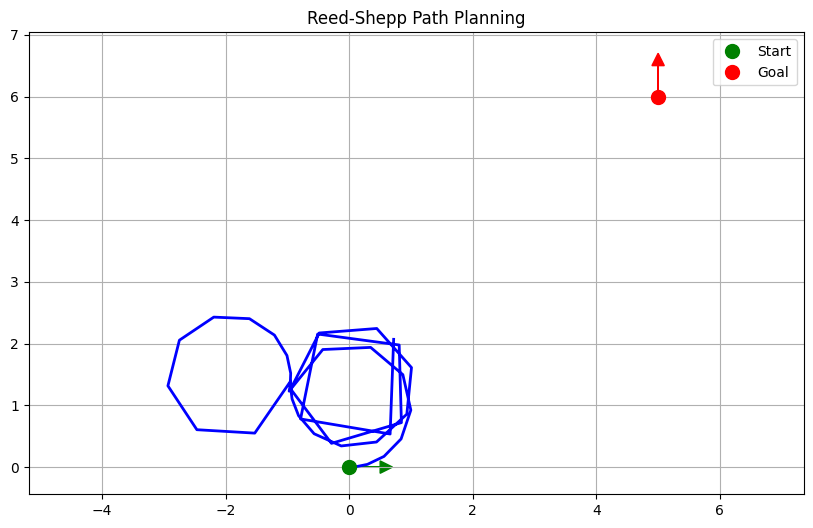

In [27]:
# Initialize the planner with a turning radius of 1.0
planner = ReedShepp(radius=1.0)

# Start position is (0, 0, 0)
start_x, start_y, start_yaw = 0.0, 0.0, 0.0

# Calculate the path
path = planner.calc_shortest_path(start_x, start_y, start_yaw, target_x, target_y, target_theta)

# Display path information
print("Reed-Shepp path from (0,0,0) to ({:.2f},{:.2f},{:.2f}):".format(
    target_x, target_y, target_theta))
print(path)

# Generate points along the path for visualization
x_path_local, y_path_local, yaw_path_local = planner.generate_path_points(path)
# Przekształcenie ścieżki lokalnej na globalną:
x_path, y_path, yaw_path = [], [], []
for xl, yl, yw in zip(x_path_local, y_path_local, yaw_path_local):
    xg = start_x + xl*cos(start_yaw) - yl*sin(start_yaw)
    yg = start_y + xl*sin(start_yaw) + yl*cos(start_yaw)
    ygaw = planner._mod2pi(yw + start_yaw)
    x_path.append(xg)
    y_path.append(yg)
    yaw_path.append(ygaw)

# Plot the path
plt.figure(figsize=(10, 6))
plt.plot(x_path, y_path, 'b-', linewidth=2)
plt.plot(start_x, start_y, 'go', markersize=10, label='Start')
plt.plot(target_x, target_y, 'ro', markersize=10, label='Goal')

# Plot orientation arrows
arrow_length = 0.5
plt.arrow(start_x, start_y, 
          arrow_length * cos(start_yaw), 
          arrow_length * sin(start_yaw),
          head_width=0.2, head_length=0.2, fc='g', ec='g')
plt.arrow(target_x, target_y, 
          arrow_length * cos(target_theta), 
          arrow_length * sin(target_theta),
          head_width=0.2, head_length=0.2, fc='r', ec='r')

plt.axis('equal')
plt.grid(True)
plt.title('Reed-Shepp Path Planning')
plt.legend()
plt.show()